In [1]:
from obspy.imaging.beachball import beach
from pyrocko import moment_tensor as pmt
from obspy import read_events, UTCDateTime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import os
#%matplotlib inline

In [2]:
# Load quick CMT events from .ndk (https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_QUICK/qcmt.ndk)
catCMT = read_events("https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_QUICK/qcmt.ndk")

# Load all earthquakes from .ndk (https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/jan76_dec17.ndk)
AllcatCMT = read_events('https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/jan76_dec17.ndk')

In [3]:
mindepth = 1 # [km] minimum depth
maxdepth = 900 # [km] maximum depth
minmag = 0 # minimum magnitude
maxmag = 10 # maximum magnitude
tstart = "2021-01-31T00:00:00" # start time for quick cmts
tend =   "2021-02-12T00:00:00" # end time for quick cmts
latmin = 1 # minimum latitude of search region
latmax = 11 # maximum latitude of search region
lonmin = 120 # minimum longitude [-180, 180] NB this can cross the dateline; lonmin=170, lonmax=-170 is allowed
lonmax = 130 # maximum longitude [-180, 180]
dateline = 0 # do not change; this is a check 
plot_best_dc = 1
mt_width_factor = 3 # the size is divided by this... smaller numbers mean larger bb

# if crossing dateline, need to do two gcmt searches.
dateline = 0 # do not change; this is a flag that is automatically changed if needed
if lonmax < lonmin:
    dateline = 1
    bblonmax = lonmin # these are for the beach ball searches...
    bblonmin = lonmax
else:
    bblonmax = lonmax
    bblonmin = lonmin

figdir = './figs/' # directory for saving figures
ofn = 'GCMTevents.pdf' # output file name within figdir

In [4]:
# these take a while; we want to only do them once unless we have to do them twice bc of dateline
if dateline == 0:
    cat_filt = catCMT.filter("depth >= "+str(mindepth*1000),
                             "depth <= "+str(maxdepth*1000),
                             "magnitude >= "+str(minmag),
                             "magnitude <= "+str(maxmag),
                             "time >= "+str(UTCDateTime(tstart)),
                             "time <= "+str(UTCDateTime(tend)),
                             "latitude >= "+str(latmin),
                             "latitude <= "+str(latmax),
                             "longitude >= "+str(bblonmin),
                             "longitude <= "+str(bblonmax))
    Allcat_filt = AllcatCMT.filter("depth >= "+str(mindepth*1000),
                                   "depth <= "+str(maxdepth*1000),
                                   "magnitude >= "+str(minmag),
                                   "magnitude <= "+str(maxmag),
                                   "latitude >= "+str(latmin),
                                   "latitude <= "+str(latmax),
                                   "longitude >= "+str(bblonmin),
                                   "longitude <= "+str(bblonmax))
else:     
    cat_filt = catCMT.filter("depth >= "+str(mindepth*1000),
                             "depth <= "+str(maxdepth*1000),
                             "magnitude >= "+str(minmag),
                             "magnitude <= "+str(maxmag),
                             "time >= "+str(UTCDateTime(tstart)),
                             "time <= "+str(UTCDateTime(tend)),
                             "latitude >= "+str(latmin),
                             "latitude <= "+str(latmax),
                             "longitude >= "+str(bblonmin),)
    cat_filt2 = catCMT.filter("depth >= "+str(mindepth*1000),
                             "depth <= "+str(maxdepth*1000),
                             "magnitude >= "+str(minmag),
                             "magnitude <= "+str(maxmag),
                             "time >= "+str(UTCDateTime(tstart)),
                             "time <= "+str(UTCDateTime(tend)),
                             "latitude >= "+str(latmin),
                             "latitude <= "+str(latmax),
                             "longitude <= "+str(bblonmax))
    cat_filt += cat_filt2 # add filtered catalogues together
    Allcat_filt = AllcatCMT.filter("depth >= "+str(mindepth*1000),
                             "depth <= "+str(maxdepth*1000),
                             "magnitude >= "+str(minmag),
                             "magnitude <= "+str(maxmag),
                             "latitude >= "+str(latmin),
                             "latitude <= "+str(latmax),
                             "longitude >= "+str(bblonmin))
    Allcat_filt2 = AllcatCMT.filter("depth >= "+str(mindepth*1000),
                             "depth <= "+str(maxdepth*1000),
                             "magnitude >= "+str(minmag),
                             "magnitude <= "+str(maxmag),
                             "latitude >= "+str(latmin),
                             "latitude <= "+str(latmax),
                             "longitude <= "+str(bblonmax))
    Allcat_filt += Allcat_filt2 

In [5]:
nEq = 200 # number of earthquakes from catalogue to plot

Allcat_filt_trunc = Allcat_filt[len(Allcat_filt)-nEq:len(Allcat_filt)] # truncate 
# bug here... if not crossing the dateline, this pulls the most recent nEq events.
# if crossing the dateline, it looks at events in the western hemisphere first,
# and eastern hemisphere last, because of the way I've added the Allcat_filt objects above

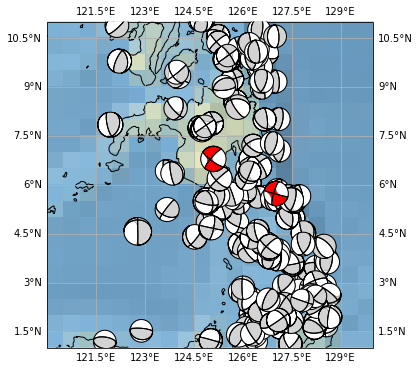

In [6]:

parspace = 30 # spacing between lat lon labels

# set up ability to plot over date line
dateline = 0
if lonmin > lonmax:
    dateline = 1
    lonmin += 360

# initialize fig
fig = plt.figure(figsize=(12, 6))
if dateline == 1:
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
else:
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img() # this is the "topo"
ax.gridlines(draw_labels=True)

obj = {} # for full moment tensor
objdc = {} # for best-fit dc nodal planes

# first for events in the full catalogue...
for iev,ev in enumerate(Allcat_filt_trunc):
    mt = ev.focal_mechanisms[0].moment_tensor.tensor
    mt_vec = [mt.m_rr, mt.m_tt, mt.m_pp, mt.m_rt, mt.m_rp, mt.m_tp ]
    ## for plotting best dc fit
    if plot_best_dc == 1:
        full_mt = pmt.MomentTensor(mnn=mt.m_rr,mee=mt.m_tt,mdd=mt.m_pp,mne=mt.m_rt,mnd=mt.m_rp,med=mt.m_tp)
        decomp_mt = pmt.MomentTensor.standard_decomposition(full_mt) # decompose mt
        dc_mt = decomp_mt[1][2] # isolate the dc component from decomposition
        dc_vec = [dc_mt[0,0],dc_mt[1,1],dc_mt[2,2],dc_mt[0,1],dc_mt[0,2],dc_mt[1,2]] # turn into vector
    
    lon = ev.origins[1].longitude
    lat = ev.origins[1].latitude

    x = lon
    y = lat
    #plot beachballs also across dateline
    if dateline == 1:
        if lon < 0:
            x = lon+180
        else:
            x = lon-180
    # set up function to scale beach ball to size of map... 
    width = ((latmin-latmax)**2 +(lonmin-lonmax)**2)**0.5 / 15 * np.sqrt(ev.magnitudes[0].mag)/mt_width_factor # width of beachballs in degrees
    if plot_best_dc == 1:
        obj[iev] = beach(mt_vec, xy=(x, y), width=width, linewidth=0.2, alpha=1, facecolor='lightgrey', nofill=False)
        objdc[iev] = beach(dc_vec, xy=(x, y), width=width, linewidth=1, alpha=1, nofill=True)
        ax.add_collection(obj[iev])
        ax.add_collection(objdc[iev])
    else:
        obj[iev] = beach(mt_vec, xy=(x, y), width=width, linewidth=1, alpha=1, facecolor='lightgrey', nofill=False)
        ax.add_collection(obj[iev])

# now for events in the quick cmt catalogue... 
for iev,ev in enumerate(cat_filt):
    mt = ev.focal_mechanisms[0].moment_tensor.tensor
    mt_vec = [mt.m_rr, mt.m_tt, mt.m_pp, mt.m_rt, mt.m_rp, mt.m_tp ]
    ## for plotting best dc fit, same as above
    if plot_best_dc == 1:
        full_mt = pmt.MomentTensor(mnn=mt.m_rr,mee=mt.m_tt,mdd=mt.m_pp,mne=mt.m_rt,mnd=mt.m_rp,med=mt.m_tp)
        decomp_mt = pmt.MomentTensor.standard_decomposition(full_mt)
        dc_mt = decomp_mt[1][2]
        dc_vec = [dc_mt[0,0],dc_mt[1,1],dc_mt[2,2],dc_mt[0,1],dc_mt[0,2],dc_mt[1,2]]
    lon = ev.origins[1].longitude
    lat = ev.origins[1].latitude

    x = lon
    y = lat
    #plot beachballs also across dateline
    if dateline == 1:
        if lon < 0:
            x = lon+180
        else:
            x = lon-180
    width = ((latmin-latmax)**2 +(lonmin-lonmax)**2)**0.5 / 15 * np.sqrt(ev.magnitudes[0].mag)/mt_width_factor # width of beachballs in degrees
    
    if plot_best_dc == 1:
        obj[iev] = beach(mt_vec, xy=(x, y), width=width, linewidth=0.2, alpha=1, facecolor='r', nofill=False)
        objdc[iev] = beach(dc_vec, xy=(x, y), width=width, linewidth=1, alpha=1, nofill=True)
        ax.add_collection(obj[iev])
        ax.add_collection(objdc[iev])
    else:
        obj[iev] = beach(mt_vec, xy=(x, y), width=width, linewidth=1, alpha=1, facecolor='r', nofill=False)
        ax.add_collection(obj[iev])

In [7]:
# use this to save the above figure
if not os.path.exists(figdir):
    os.makedirs(figdir)
fig.savefig(figdir+ofn, bbox_inches="tight")